In [1]:
!ls

/bin/bash: /home/apsisdev/anaconda3/envs/eblict/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Memo_Classifier_pytorch.ipynb  WordImage_LANG_Classifier_pytorch.ipynb
multilingual_words


In [2]:
!nvidia-smi

/bin/bash: /home/apsisdev/anaconda3/envs/eblict/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Thu May 26 13:58:37 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.73.05    Driver Version: 510.73.05    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
|  0%   58C    P8    33W / 370W |    254MiB / 24576MiB |     13%      Default |
|                               |                      |                  N/A |
+-------------------------------+-----------

# Dataset Link 

https://www.kaggle.com/datasets/mobassir/multilingual-document-images

In [3]:
# Import basic packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import zipfile
from torch import onnx
from sklearn import metrics
# Import PyTorch packages
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import os, random, shutil
import timm 
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn.modules.loss import _WeightedLoss
import random
import seaborn as sns
sns.set_style("darkgrid")
from torchvision import models 
from sklearn.metrics import classification_report, confusion_matrix
import cv2
from albumentations import Compose, Normalize, HorizontalFlip, VerticalFlip
from albumentations.pytorch import ToTensorV2
from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, RandomResizedCrop,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, Normalize, Cutout, CoarseDropout, ShiftScaleRotate, CenterCrop, Resize
)

In [4]:
!pwd


/bin/bash: /home/apsisdev/anaconda3/envs/eblict/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/home/apsisdev/mobassir/data/mlt_reader_research


In [5]:

!ls "/home/apsisdev/mobassir/data/mlt_reader_research/multilingual_words/"

/bin/bash: /home/apsisdev/anaconda3/envs/eblict/lib/libtinfo.so.6: no version information available (required by /bin/bash)
ar_words  en_words   multilingual_words.zip		     train
bn_words  model.pth  outlet_convnext_base_384_in22ft1k.onnx  val


In [6]:
bn = len(os.listdir("/home/apsisdev/mobassir/data/mlt_reader_research/multilingual_words/bn_words"))
en = len(os.listdir("/home/apsisdev/mobassir/data/mlt_reader_research/multilingual_words/en_words"))
ar = len(os.listdir("/home/apsisdev/mobassir/data/mlt_reader_research/multilingual_words/ar_words"))
print(bn,en,ar)

1150520 337188 112299


In [7]:
train =  0# 1 = train, 0 = inference
image_size = 384
batch_size= 32
no_epochs = 5
sample_size = 112299
split_percent = 0.30
max_patience = 3
num_workers = 8
lr = 0.00003
lr1 = 0.000003
model_name = 'convnext_base_384_in22ft1k'
use_amp = True
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

train_dir = '/home/apsisdev/mobassir/data/mlt_reader_research/multilingual_words'

if os.path.exists(train_dir+'/train'):
    shutil.rmtree(train_dir+'/train')
if os.path.exists(train_dir+'/val'):
    shutil.rmtree(train_dir+'/val')

    

In [8]:
os.makedirs(train_dir+'/train', exist_ok=True)
os.makedirs(train_dir+'/val', exist_ok=True)

os.makedirs(train_dir+'/train/ar_words', exist_ok=True)
os.makedirs(train_dir+'/val/ar_words', exist_ok=True)

os.makedirs(train_dir+'/train/bn_words', exist_ok=True)
os.makedirs(train_dir+'/val/bn_words', exist_ok=True)

os.makedirs(train_dir+'/train/en_words', exist_ok=True)
os.makedirs(train_dir+'/val/en_words', exist_ok=True)

In [9]:
#ls /home/apsisdev/mobassir/data/mlt_reader_research/multilingual_words/ar_words/

In [10]:
def custom_random_sampler(source = '/content/train/mlt_words/' ,destination_train = '/content/sample_data',destination_val = '/content/sample_data',sample_size = 100):
    all_data = []
    if(len(os.listdir(source)) < sample_size):
        sample_size = len(os.listdir(source))
        print("updated sample size = ",sample_size)
    source_data = os.listdir(source)
    random.shuffle(source_data)
    for idx,data in enumerate(source_data):
        if(idx>sample_size):
            break
        all_data.append(source+data)
    
    for i in range(len(all_data)):
        shutil.copy(f'{all_data[i]}', destination_train)
        
    random.shuffle(all_data)
    val = int(len(all_data)*split_percent)
    all_train = os.listdir(destination_train)
    for i in range(val):
        shutil.move(destination_train+'/'+all_train[i], destination_val)
    



In [11]:
custom_random_sampler(source = '/home/apsisdev/mobassir/data/mlt_reader_research/multilingual_words/ar_words/' ,
                      destination_train = '/home/apsisdev/mobassir/data/mlt_reader_research/multilingual_words/train/ar_words',
                     destination_val = '/home/apsisdev/mobassir/data/mlt_reader_research/multilingual_words/val/ar_words',
                     sample_size = sample_size)

In [12]:
custom_random_sampler(source = '/home/apsisdev/mobassir/data/mlt_reader_research/multilingual_words/bn_words/' ,
                      destination_train = '/home/apsisdev/mobassir/data/mlt_reader_research/multilingual_words/train/bn_words',
                     destination_val = '/home/apsisdev/mobassir/data/mlt_reader_research/multilingual_words/val/bn_words',
                     sample_size = sample_size)

In [13]:
custom_random_sampler(source = '/home/apsisdev/mobassir/data/mlt_reader_research/multilingual_words/en_words/' ,
                      destination_train = '/home/apsisdev/mobassir/data/mlt_reader_research/multilingual_words/train/en_words',
                     destination_val = '/home/apsisdev/mobassir/data/mlt_reader_research/multilingual_words/val/en_words',
                     sample_size = sample_size)

In [14]:
train_dir = '/home/apsisdev/mobassir/data/mlt_reader_research/multilingual_words/train'
test_dir = '/home/apsisdev/mobassir/data/mlt_reader_research/multilingual_words/val'
save_dir = '/home/apsisdev/mobassir/data/mlt_reader_research/multilingual_words/'

In [15]:
# Make sure all images have size [image_size, image_size]

def get_train_transforms():
    return Compose([
            Resize(image_size, image_size),
            Transpose(p=0.5),
            #HorizontalFlip(p=0.5),
            #VerticalFlip(p=0.5),
            ShiftScaleRotate(p=0.5),
            HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
            RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            CoarseDropout(p=0.2),
            Cutout(p=0.1),
            ToTensorV2(p=1.0),
        ], p=1.)
  
        
def get_valid_transforms():
    return Compose([
            Resize(image_size, image_size),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.)

# train_transform = get_train_transforms()
# transform = get_valid_transforms()

train_transform = T.Compose([
    
    T.Resize((image_size,image_size)), 
    #T.RandomPerspective(),
    #T.RandomHorizontalFlip(),
    #T.RandomVerticalFlip(),
    
    T.AutoAugment(),
    
    #T.FiveCrop(image_size),
    #T.TenCrop(image_size),
    
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  
    
])

transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    T.Resize((image_size, image_size)),
    
])



Train dataset has 235830 images
Validation dataset has 101069 images
First image has size: torch.Size([3, 384, 384]) and class: 0.
Another random image has size: torch.Size([3, 384, 384]) and class: 0.
There are 3 classes in total: 
['ar_words', 'bn_words', 'en_words']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images.shape: torch.Size([32, 3, 384, 384])


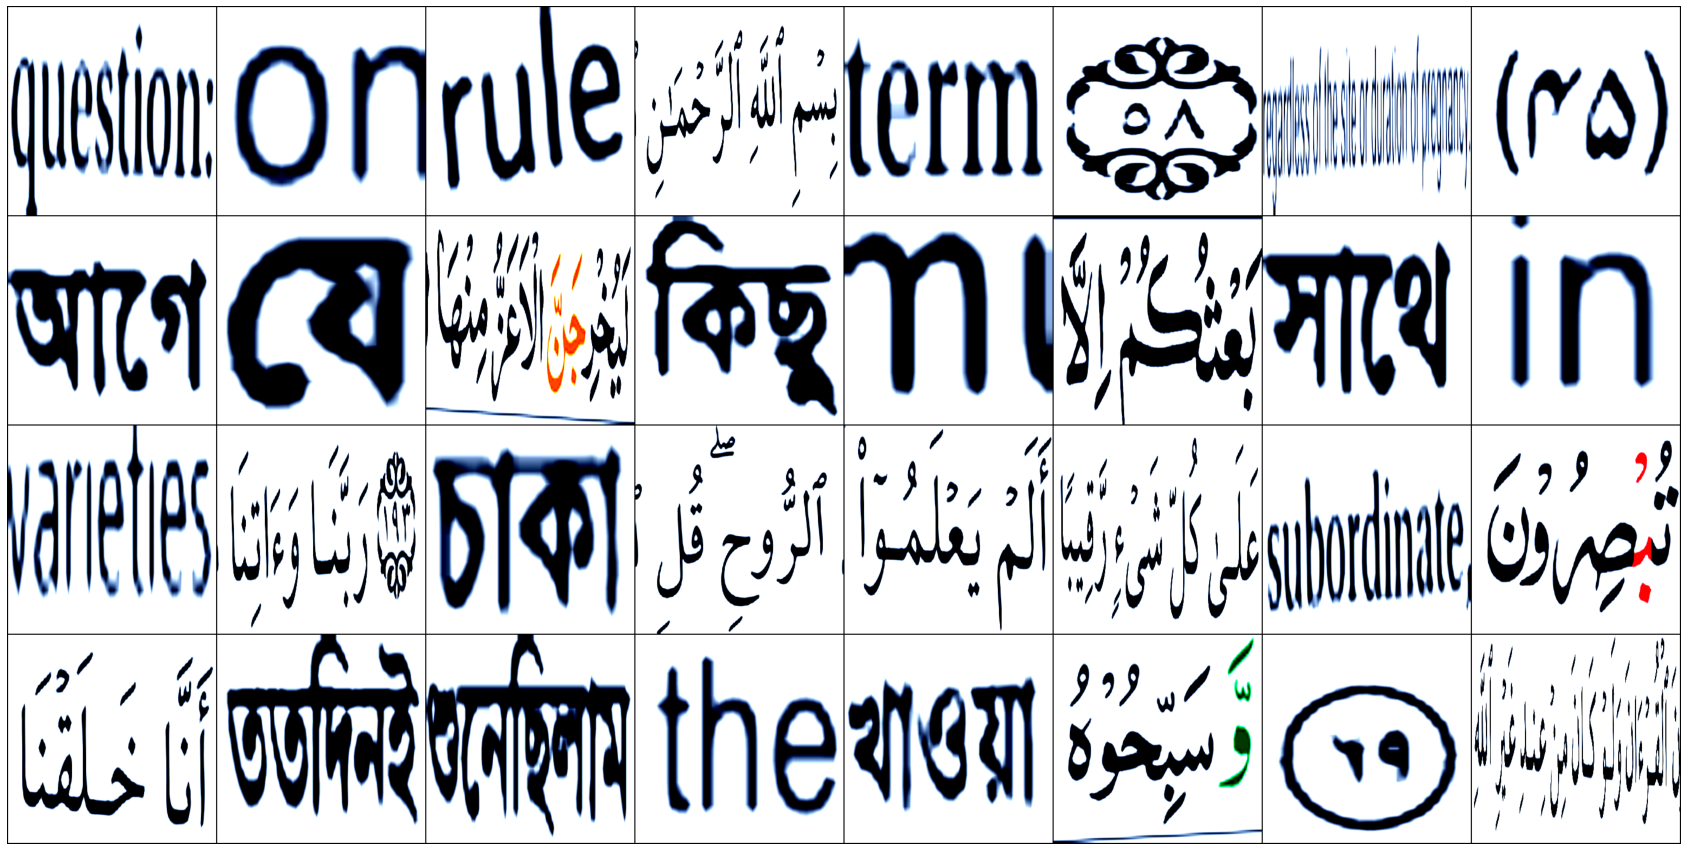

In [16]:
# Load train data and test data
train_data = ImageFolder(root=train_dir, transform=train_transform)
validate_data = ImageFolder(root=test_dir, transform=transform)

# Store data in ImageFolder to DataLoader
train_ds = DataLoader(train_data,batch_size,  shuffle=True, pin_memory=True, num_workers=num_workers)
validate_ds = DataLoader(validate_data,batch_size, shuffle=True, pin_memory=True, num_workers=num_workers)

# View train dataset size
print("Train dataset has {0} images".format(len(train_data)))

# View valid dataset size
print("Validation dataset has {0} images".format(len(validate_data)))

# View image size and class
fst_img, fst_lbl = train_data[0]
print("First image has size: {0} and class: {1}.".format(fst_img.shape, fst_lbl))

sc_img, sc_lbl = train_data[10]
print("Another random image has size: {0} and class: {1}.".format(sc_img.shape, sc_lbl))

# View all classes
classes = train_data.classes
print("There are {0} classes in total: ".format(len(classes)))
print(classes)

for images, _ in validate_ds:
    print('images.shape:', images.shape)
    plt.figure(figsize=(30,30))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=8).permute((1, 2, 0)))
    break

In [17]:
def get_model(model_name=None,pretrained = True):
    #model = models.efficientnet_b4(pretrained = pretrained)#resnext50_32x4d
    
    model = timm.create_model(model_name, pretrained=pretrained)
#     for q in model.parameters():
#         q.requires_grad = False
    #print(model)
    model.head.fc = nn.Sequential(
      nn.Linear(in_features=model.head.fc.in_features, out_features=model.head.fc.in_features//2) ,
      nn.ReLU(),
      nn.Linear(in_features=(model.head.fc.in_features)//2, out_features=model.head.fc.in_features//4) ,
      nn.ReLU(),
      nn.Dropout(p=0.1), 
      nn.Linear(in_features=model.head.fc.in_features//4 , out_features=len(classes)),
      nn.LogSoftmax(dim=1)
    )
    return model


In [18]:
model = get_model(model_name = model_name,pretrained = True)
model

ConvNeXt(
  (stem): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
    (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
  )
  (stages): Sequential(
    (0): ConvNeXtStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): ConvNeXtBlock(
          (conv_dw): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (norm): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=128, out_features=512, bias=True)
            (act): GELU()
            (drop1): Dropout(p=0.0, inplace=False)
            (fc2): Linear(in_features=512, out_features=128, bias=True)
            (drop2): Dropout(p=0.0, inplace=False)
          )
          (drop_path): Identity()
        )
        (1): ConvNeXtBlock(
          (conv_dw): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (norm): LayerNorm((128,), eps=1e-06, elemen

In [19]:

# https://stackoverflow.com/questions/55681502/label-smoothing-in-pytorch

class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes = len(classes), smoothing=0.0, dim=-1, weight = None):
        """if smoothing == 0, it's one-hot method
           if 0 < smoothing < 1, it's smooth method
        """
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.weight = weight
        self.cls = classes
        self.dim = dim

    def forward(self, pred, target):
        assert 0 <= self.smoothing < 1
        pred = pred.log_softmax(dim=self.dim)

        if self.weight is not None:
            pred = pred * self.weight.unsqueeze(0)   

        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

In [20]:
# Perform training and cross validation
# Calculate accuracy
def calcAccuracy(scores, label):
    _, prediction = torch.max(scores, dim=1)
    return torch.tensor(torch.sum(prediction == label).item()/len(scores))

class EarlyStopping():
    """
    Early stopping to stop the training when the loss does not improve after
    certain epochs.
    """
    def __init__(self, patience=5):
        """
        :param patience: how many epochs to wait before stopping when acc is
               not improving

        """
        self.patience = patience
        self.counter = 0
        self.best_acc = None
        self.early_stop = False
    def __call__(self, val_acc):
        if self.best_acc == None:
            self.best_acc = val_acc
        elif val_acc > self.best_acc:
            self.best_acc = val_acc
            # reset counter if validation acc improves
            self.counter = 0
        else:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True
                
#@torch.no_grad()
# Cross validate
def validate(validate_ds, model,softmax):
    model.eval()
    validate_length = 0
    accuracy = 0
    label = []
    preds = []
    for img, lbl in validate_ds:
        with torch.no_grad():
            scores = model(img)
            loss = softmax(scores, lbl)
            lbl_gpu = lbl
            lbl = lbl.detach().cpu()
            _, prediction = torch.max(scores, dim=1)
            prediction = prediction.detach().cpu()
            label.append(lbl)
            preds.append(prediction)
            accuracy += calcAccuracy(scores, lbl_gpu)
            validate_length += 1
            
    accuracy /= validate_length
    print("accuracy -> ",accuracy)
    y_true = torch.cat(label, dim=0).numpy()
    y_pred = torch.cat(preds, dim=0).numpy()
    print('recall_score = ',metrics.recall_score(y_true, y_pred, average='macro'))
    print('precision_score = ',metrics.precision_score(y_true, y_pred, average='macro'))
 
    macro = metrics.f1_score(y_true, y_pred, average='macro')
    #print(macro)
    return loss, macro

# Run the training and cross validation
def fit(train_ds, validate_ds, no_epochs, optimizer, model):
    model.train()
    history = []
    softmax = LabelSmoothingLoss(smoothing=0.01) #nn.CrossEntropyLoss(reduction  = 'mean')
    valid_acc = 0
    #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max',patience = max_patience)
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=lr, max_lr=lr1,cycle_momentum=False)
    early_stopping = EarlyStopping(patience = max_patience)
    for index in range(no_epochs):
        # Train
#         if(index<3):
#             for q in model.parameters():
#                 q.requires_grad = False
#         else:
#             for q in model.parameters():
#                 q.requires_grad = True
        model = model.to(device)
        for img, lbl in train_ds:
            with torch.cuda.amp.autocast(enabled=use_amp):
                scores = model(img)
                loss = softmax(scores, lbl)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad() # set_to_none=True here can modestly improve performance
            scheduler.step()

#             loss.backward()
#             optimizer.step()
#             optimizer.zero_grad()
            
        # Validate
        valid_loss, macro = validate(validate_ds, model, softmax)
        #scheduler.step(macro)
            
        # Print epoch record
        print(f"Epoch [{index + 1}/{no_epochs}] => loss: {loss}, val_loss: {valid_loss}, Validation F1 Macro: {macro}")
        if(macro > valid_acc):
          print("----------->>> val F1 improved, saving best weight....")
          torch.save(model.state_dict(), f'{save_dir}/model.pth')
          valid_acc = macro
        history.append({"loss": loss,
                       "valid_loss": valid_loss,
                       "F1 Macro": macro
                       })
        early_stopping(macro)
        if early_stopping.early_stop:
            break
    return history

In [21]:

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class to_GPU():
    def __init__(self, ds, device):
        self.ds = ds
        self.device = device
    
    def __iter__(self):
        for batch in self.ds:
            yield to_device(batch, self.device)

In [22]:
# Initialize model and data before training
device = torch.device('cuda:0')
model = model.to(device)
train_ds = to_GPU(train_ds, device)
validate_ds = to_GPU(validate_ds, device)


In [23]:

# train_ds = DataLoader(train_ds, batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
# validate_ds = DataLoader(validate_ds, batch_size, num_workers=num_workers, pin_memory=True)


In [24]:
%%time

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
if(train):
    history = fit(train_ds, validate_ds, no_epochs, optimizer, model)
    print(history)

CPU times: user 481 µs, sys: 408 µs, total: 889 µs
Wall time: 893 µs


In [25]:
'''
training log : 

accuracy ->  tensor(0.9972)
recall_score =  0.9972197228442803
precision_score =  0.9972211751529327
Epoch [1/5] => loss: 0.06333701312541962, val_loss: 0.08893957734107971, Validation F1 Macro: 0.9972201004789901
----------->>> val F1 improved, saving best weight....
accuracy ->  tensor(0.9984)
recall_score =  0.9983971437348824
precision_score =  0.9983989006819792
Epoch [2/5] => loss: 0.0630369633436203, val_loss: 0.06295521557331085, Validation F1 Macro: 0.9983973016973918
----------->>> val F1 improved, saving best weight....
accuracy ->  tensor(0.9986)
recall_score =  0.9986346055647976
precision_score =  0.9986367392861308
Epoch [3/5] => loss: 0.0629790648818016, val_loss: 0.0629655122756958, Validation F1 Macro: 0.998634721688922
----------->>> val F1 improved, saving best weight....
accuracy ->  tensor(0.9986)
recall_score =  0.9986247067329733
precision_score =  0.9986257792200689
Epoch [4/5] => loss: 0.06296129524707794, val_loss: 0.06297516077756882, Validation F1 Macro: 0.9986248203291345
INFO: Early stopping counter 1 of 3
accuracy ->  tensor(0.9987)
recall_score =  0.9987137530469159
precision_score =  0.9987142786222329
Epoch [5/5] => loss: 0.0629962608218193, val_loss: 0.06295380741357803, Validation F1 Macro: 0.9987138204704182
----------->>> val F1 improved, saving best weight....
[{'loss': tensor(0.0633, device='cuda:0', grad_fn=<MeanBackward0>), 'valid_loss': tensor(0.0889, device='cuda:0'), 'F1 Macro': 0.9972201004789901}, {'loss': tensor(0.0630, device='cuda:0', grad_fn=<MeanBackward0>), 'valid_loss': tensor(0.0630, device='cuda:0'), 'F1 Macro': 0.9983973016973918}, {'loss': tensor(0.0630, device='cuda:0', grad_fn=<MeanBackward0>), 'valid_loss': tensor(0.0630, device='cuda:0'), 'F1 Macro': 0.998634721688922}, {'loss': tensor(0.0630, device='cuda:0', grad_fn=<MeanBackward0>), 'valid_loss': tensor(0.0630, device='cuda:0'), 'F1 Macro': 0.9986248203291345}, {'loss': tensor(0.0630, device='cuda:0', grad_fn=<MeanBackward0>), 'valid_loss': tensor(0.0630, device='cuda:0'), 'F1 Macro': 0.9987138204704182}]
CPU times: user 4h 57min 50s, sys: 1h 8min 32s, total: 6h 6min 22s
Wall time: 5h 53min 23s
'''

"\ntraining log : \n\naccuracy ->  tensor(0.9972)\nrecall_score =  0.9972197228442803\nprecision_score =  0.9972211751529327\nEpoch [1/5] => loss: 0.06333701312541962, val_loss: 0.08893957734107971, Validation F1 Macro: 0.9972201004789901\n----------->>> val F1 improved, saving best weight....\naccuracy ->  tensor(0.9984)\nrecall_score =  0.9983971437348824\nprecision_score =  0.9983989006819792\nEpoch [2/5] => loss: 0.0630369633436203, val_loss: 0.06295521557331085, Validation F1 Macro: 0.9983973016973918\n----------->>> val F1 improved, saving best weight....\naccuracy ->  tensor(0.9986)\nrecall_score =  0.9986346055647976\nprecision_score =  0.9986367392861308\nEpoch [3/5] => loss: 0.0629790648818016, val_loss: 0.0629655122756958, Validation F1 Macro: 0.998634721688922\n----------->>> val F1 improved, saving best weight....\naccuracy ->  tensor(0.9986)\nrecall_score =  0.9986247067329733\nprecision_score =  0.9986257792200689\nEpoch [4/5] => loss: 0.06296129524707794, val_loss: 0.06

In [26]:
if(train):
    train_loss = []
    valid_loss = []
    macro = []
    for x in history:
        train_loss.append(x["loss"])
        valid_loss.append(x["valid_loss"])
        macro.append(x["F1 Macro"])

    train_loss = [x.item() for x in train_loss]
    valid_loss = [x.item() for x in valid_loss]
    valid_acr = [x.item() for x in macro]
    epochs = np.arange(no_epochs)

In [27]:
if(train):
    plt.plot(epochs, train_loss)
    plt.plot(epochs, valid_loss)
    plt.xlabel("Epochs")
    plt.ylabel("F1 Macro")
    plt.title("Loss of training and validation F1 Macro over iterations")
    plt.legend(["training", "validation"])
    plt.show()

In [28]:
if(train):
    plt.plot(epochs, valid_acr)
    plt.xlabel("Epochs")
    plt.ylabel("F1 Macro")
    plt.title("F1 Macro")
    plt.show()

In [29]:
TEST_PATH = '/home/apsisdev/mobassir/data/mlt_reader_research/multilingual_words/val/'

# Inference

bn_words
tensor([1], device='cuda:0')
tensor([1], device='cuda:0')
tensor([1], device='cuda:0')
tensor([1], device='cuda:0')
tensor([1], device='cuda:0')
tensor([1], device='cuda:0')
tensor([1], device='cuda:0')
tensor([1], device='cuda:0')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


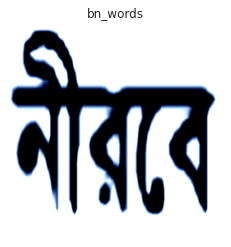

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


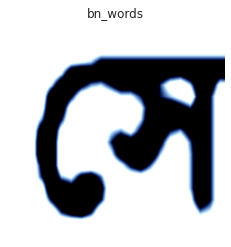

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


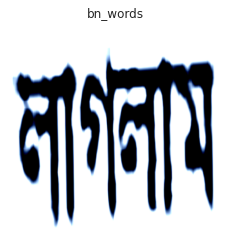

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


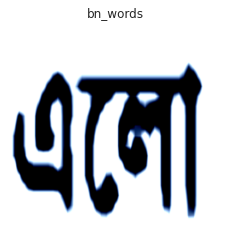

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


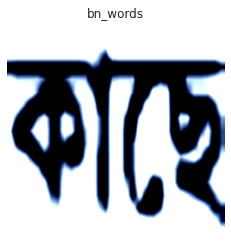

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


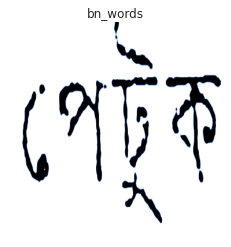

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


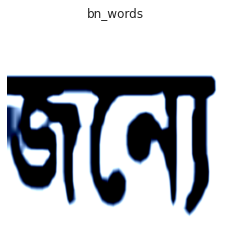

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


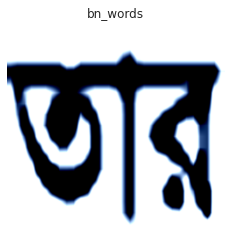

In [30]:

brands = os.listdir(TEST_PATH)
index = 0

print(brands[index])
TEST_PATH = TEST_PATH+brands[index]
datalist = os.listdir(TEST_PATH)
random.shuffle(datalist)
test_data = []
for i in datalist:
    if(len(test_data)>7):
        break
    img = plt.imread(TEST_PATH + "/" + i).copy()
    test_data.append(transform(img))

test_ds = DataLoader(test_data, pin_memory=True, num_workers=8)
test_ds = to_GPU(test_ds, device)

model = get_model(model_name = model_name,pretrained = False)

model.load_state_dict(
        torch.load(f'{save_dir}/model.pth')
    )
model = model.to(device)

model.eval()

predictions = []
count = 0

for img in test_ds:
    scores = model(img)
    _, prediction = torch.max(scores, dim=1)
    print(prediction)
    predictions.append(prediction.to('cpu').numpy())
    count += 1
    if count == 8:
        break
    
predicted_classes = [classes[x.item()] for x in predictions]

count = 0
for img in test_ds:
    plt.imshow(img[0].to('cpu').permute(1, 2, 0))
    plt.title(predicted_classes[count])
    plt.axis("off")
    plt.show()
    count += 1
    if count == 8:
        break

In [31]:
predictions

[array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1])]

In [32]:
#onnx
TEST_PATH = '/home/apsisdev/mobassir/data/mlt_reader_research/multilingual_words/val/'
index = 1
brands = os.listdir(TEST_PATH)
print(brands[index])
TEST_PATH = TEST_PATH+brands[index]
datalist = os.listdir(TEST_PATH)
random.shuffle(datalist)
for i in datalist:
    img = cv2.imread(TEST_PATH + "/" + i).copy()
    break

input_tensor = transform(img)
inp_batch = input_tensor.unsqueeze(0)
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"
inp_batch.to(device)

model = get_model(model_name = model_name,pretrained = False)

model.load_state_dict(
        torch.load(f'{save_dir}/model.pth')
    )
model = model.to(device)
model.eval()

onnx.export(model,
          inp_batch,
          f"{save_dir}/outlet_{model_name}.onnx",
          export_params=True,
          verbose=True,
          opset_version=10)

ar_words
graph(%input.1 : Float(1, 3, 384, 384, strides=[442368, 147456, 384, 1], requires_grad=0, device=cpu),
      %stem.0.weight : Float(128, 3, 4, 4, strides=[48, 16, 4, 1], requires_grad=1, device=cpu),
      %stem.0.bias : Float(128, strides=[1], requires_grad=1, device=cpu),
      %stem.1.weight : Float(128, strides=[1], requires_grad=1, device=cpu),
      %stem.1.bias : Float(128, strides=[1], requires_grad=1, device=cpu),
      %stages.0.blocks.0.conv_dw.weight : Float(128, 1, 7, 7, strides=[49, 49, 7, 1], requires_grad=1, device=cpu),
      %stages.0.blocks.0.conv_dw.bias : Float(128, strides=[1], requires_grad=1, device=cpu),
      %stages.0.blocks.0.norm.weight : Float(128, strides=[1], requires_grad=1, device=cpu),
      %stages.0.blocks.0.norm.bias : Float(128, strides=[1], requires_grad=1, device=cpu),
      %stages.0.blocks.0.mlp.fc1.bias : Float(512, strides=[1], requires_grad=1, device=cpu),
      %stages.0.blocks.0.mlp.fc2.bias : Float(128, strides=[1], requires_gra

In [33]:
#onnx infer
#!pip install onnx
#!pip install onnxruntime

import onnx

# Load the ONNX model
model = onnx.load(f"{save_dir}/outlet_{model_name}.onnx")

# Check that the model is well formed
onnx.checker.check_model(model)

# Print a human readable representation of the graph
print(onnx.helper.printable_graph(model.graph))

graph torch-jit-export (
  %input.1[FLOAT, 1x3x384x384]
) initializers (
  %stem.0.weight[FLOAT, 128x3x4x4]
  %stem.0.bias[FLOAT, 128]
  %stem.1.weight[FLOAT, 128]
  %stem.1.bias[FLOAT, 128]
  %stages.0.blocks.0.conv_dw.weight[FLOAT, 128x1x7x7]
  %stages.0.blocks.0.conv_dw.bias[FLOAT, 128]
  %stages.0.blocks.0.norm.weight[FLOAT, 128]
  %stages.0.blocks.0.norm.bias[FLOAT, 128]
  %stages.0.blocks.0.mlp.fc1.bias[FLOAT, 512]
  %stages.0.blocks.0.mlp.fc2.bias[FLOAT, 128]
  %stages.0.blocks.1.conv_dw.weight[FLOAT, 128x1x7x7]
  %stages.0.blocks.1.conv_dw.bias[FLOAT, 128]
  %stages.0.blocks.1.norm.weight[FLOAT, 128]
  %stages.0.blocks.1.norm.bias[FLOAT, 128]
  %stages.0.blocks.1.mlp.fc1.bias[FLOAT, 512]
  %stages.0.blocks.1.mlp.fc2.bias[FLOAT, 128]
  %stages.0.blocks.2.conv_dw.weight[FLOAT, 128x1x7x7]
  %stages.0.blocks.2.conv_dw.bias[FLOAT, 128]
  %stages.0.blocks.2.norm.weight[FLOAT, 128]
  %stages.0.blocks.2.norm.bias[FLOAT, 128]
  %stages.0.blocks.2.mlp.fc1.bias[FLOAT, 512]
  %stages.0.blo

In [34]:
import onnxruntime as ort

ort_session = ort.InferenceSession(f"{save_dir}/outlet_{model_name}.onnx",providers=['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider'])

input_name = ort_session.get_inputs()[0].name
output_name = ort_session.get_outputs()[0].name
print(input_name)
print(output_name)

outputs = ort_session.run([output_name], {input_name: np.array(inp_batch)})
print(outputs)

input.1
1619
[array([[-0.01012349, -5.333001  , -5.2508526 ]], dtype=float32)]


In [35]:

prediction=int(np.argmax(np.array(outputs).squeeze(), axis=0))

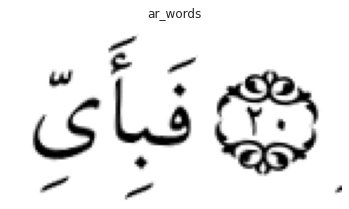

In [36]:
predicted_class = [classes[prediction]]
plt.imshow(img)
plt.title(predicted_class[0])
plt.axis("off")
plt.show()

In [37]:
!pwd

/bin/bash: /home/apsisdev/anaconda3/envs/eblict/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/home/apsisdev/mobassir/data/mlt_reader_research


In [38]:
classes

['ar_words', 'bn_words', 'en_words']

In [39]:
!nvidia-smi

/bin/bash: /home/apsisdev/anaconda3/envs/eblict/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Thu May 26 13:59:40 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.73.05    Driver Version: 510.73.05    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
| 30%   62C    P2   143W / 370W |   5401MiB / 24576MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+-----------